In [34]:
# Import libraries
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

# Training parameters
epochs = 5
batch_size = 32
training_size = 5500
testing_size = 1500

# Build our model
model = Sequential()

# Adding our first convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Downsample and dropout
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Second convolutional layers
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Downsample and dropout again
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Connecting to FC 64 neurons and adding dropout
model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))

# Sigmoid activation as recommended for binary classifiers. We'd use softmax for multi
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

train_datagen = ImageDataGenerator(
        shear_range = 0.1,
        zoom_range = [0.8, 1.2],
        rotation_range = 30,
        width_shift_range=0.1,
        brightness_range = [0.8, 1.2],
        height_shift_range=0.1,
        horizontal_flip = True,
        rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('train_face',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_face',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary')

hist = model.fit_generator(training_set,
    steps_per_epoch = int(training_size // batch_size),
    epochs = epochs,
    validation_data = test_set,
    validation_steps = int(testing_size // batch_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [35]:
# Predict for a single image
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('single_test_face.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices

if result[0][0] == 0:
    prediction = 'face'
else:
    prediction = 'non-face'
    

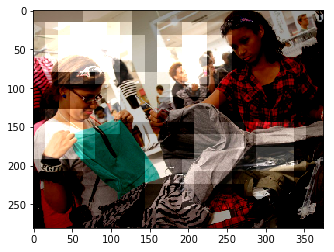

In [51]:
# Brute-force method
# Grab regions of our test and classify each one

# Open our single image
%matplotlib inline
img = Image.open("single_tests/store_with_people.jpeg") 
width, height = img.size 

# Resize base image down
img = img.resize((int(width/1.5), int(height/1.5)))
width, height = img.size 

partition_size = 64
stride_size = 16

final_img = Image.new('RGB', (width, height), (0,0,0))

# Look at each region
for i in range(0, int(width / stride_size - partition_size / stride_size)):
    for j in range(0, int(height / stride_size - partition_size / stride_size)):
        
        # Grab real x, y coordinates
        x = i * stride_size
        y = j * stride_size
        # Sample only this part of the image
        sub_img = img.crop((x, y, x+partition_size, y+partition_size)) 

        # Attempt to see if it's a face
        test_image = np.array(np.float32(sub_img))
        test_image = np.expand_dims(test_image, axis = 0)
        result = model.predict(test_image)
        # Highlight if it's a face or not
        for xx in range(x, x + partition_size):
            for yy in range(y, y + partition_size):
                if result[0][0] == 0:
                    #img.putpixel((xx, yy), tuple(map(lambda u, v: u + v, img.getpixel((xx, yy)), (64,64,64))))
                    final_img.putpixel((xx, yy), tuple(map(lambda u, v: u + v, final_img.getpixel((xx, yy)), (50,50,50))))
                #else:
                    #img.putpixel((xx, yy), tuple(map(lambda u, v: u - v, img.getpixel((xx, yy)), (64,64,64))))

# Show the final image
# Assemble the final image
for x in range(0, width):
    for y in range(0, height):
        img.putpixel((x, y), tuple(map(lambda u, v: u + v - 100, img.getpixel((x, y)), final_img.getpixel((x, y)))))
        
imshow(np.asarray(img))

In [16]:
test_image = image.load_img('store_with_people.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image.shape

(64, 64, 3)

In [18]:
img = Image.open("single_tests/one_dude.jpeg") 
sub_img = img.crop((0, 0, 64, 64)) 
test_image = np.array(np.float32(sub_img))
test_image.shape

(800, 1280, 3)

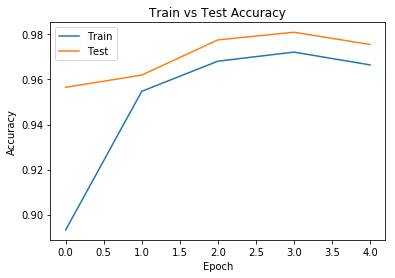

In [36]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'])

plt.show()

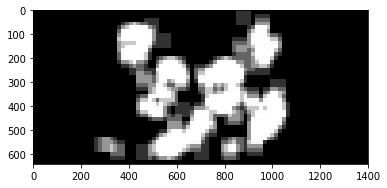

In [48]:
imshow(np.asarray(final_img))